# Week 10

## Step 1

First, SRR_.kraken files were reformatted as such:

In [3]:
import pandas as pd 
import seaborn
import numpy as np

In [ ]:
fnames = ['SRR492183.kraken', 'SRR492188.kraken', 'SRR492190.kraken', 'SRR492194.kraken', 'SRR492186.kraken', 'SRR492189.kraken', 'SRR492193.kraken', 'SRR492197.kraken']

In [ ]:
for i in fnames:
    f = open('week13_data/KRAKEN/'+i, 'r')
    L = f.readlines()
    f.close()
    f1 = open('week13_data/KRAKEN/'+i+'.formatted.txt', 'w')
    for line in L:
        current_line = line.split(';')[1::]
        out_string = ""
        for i in current_line:
            out_string += i +'\t'
        out_string = out_string.rstrip('\t')
        #print(repr(out_string))  
        f1.write(out_string)
    f1.close()

Sorting and counting were done with the following bash script: 

In [ ]:
%%bash
#!/bin/bash

for i in *formatted.txt 
do 
	cut -f 6 $i | sort | uniq -c > ${i%.*}.sorted.kraken
done

To fix formatting of those files so that Krona would recognize them, the following was run:

In [ ]:
filenames = ['SRR492183.kraken.formatted.sorted.kraken', 'SRR492189.kraken.formatted.sorted.kraken','SRR492194.kraken.formatted.sorted.kraken',
'SRR492186.kraken.formatted.sorted.kraken','SRR492190.kraken.formatted.sorted.kraken','SRR492197.kraken.formatted.sorted.kraken',
'SRR492188.kraken.formatted.sorted.kraken','SRR492193.kraken.formatted.sorted.kraken']

In [ ]:
for i in filenames:
    a = pd.read_table('week13_data/KRAKEN/'+i, names = ['1'], skipinitialspace=True)
    a[['1', '2']] = a['1'].str.split(" ", 1, expand = True)    
    a.to_csv('week13_data/KRAKEN/'+i+'.fm.txt', header =None, index=None, sep = '\t', mode='a') 

ktImportText was run on each of these files. Resulting files are stored as SRR*.html.

## Question 1: 

The microbiome consists primarily of three orders: Lactobacillales  entirely of Lactobacillales, Propionibacteriales, and Bacilliales. There are plenty of other groups, but these exist at low frequencies. The first four days are marked by the increased predominance of Lactobacillales, but then the second half of the week shows grow in the other two species.

## Step 2

First, and index was generated using bwa index assembly.fasta

To get alligned sam files, I ran the following script:

In [ ]:
%%bash
\#!/bin/bash

for i in 183 186 188 189 190 193 194 197
do 
	bwa mem -o READS/sam/SRR492${i}.sam assembly.fasta READS/SRR492${i}_1.fastq READS/SRR492${i}_2.fastq
done

Converstion to BAM: 

In [ ]:
%%bash
#!/bin/bash

for i in 183 186 188 189 190 193 194 197
do 
	samtools view -b -o READS/bam/SRR492${i}.bam READS/sam/SRR492${i}.sam
done

Sorting:

In [ ]:
%%bash
#!/bin/bash

for i in 183 186 188 189 190 193 194 197
do 
	samtools sort -o READS/sorted_bam/SRR492${i}.sorted.bam READS/bam/SRR492${i}.bam
done

Depth file generated using: 
    jgi_summarize_bam_contig_depths --outputDepth depth.txt *.bam

and did metabat analysis using:

metabat2 -i assembly.fasta -a READS/sorted_bam/depth.txt -o READS/metabat_out/

Returns: MetaBAT 2 (2.15 (Bioconda)) using minContig 2500, minCV 1.0, minCVSum 1.0, maxP 95%, minS 60, maxEdges 200 and minClsSize 200000. with random seed=1608245256
6 bins (13187322 bases in total) formed.

## Question 2: 

I think that one way to group contigs would be to use read count/abundance. We exepct different species to be found in the microbiome at really variable frequencies. We would expect a very common species to have significantly higher coverage than a rare species. From this, we can separate contigs by average coverage of a position within the contig and use that to match them. 

## Question 3:
MetBAT returns six bins totalling 13187322 bases. Running 

grep -v NODE assembly.fasta | wc -c 

returns that the assembly has 38708237 charactesr in total. Therefore, approximately 1/3 of the assembly is covered in the metaBAT bins. 

Looking at the sizes of some of my bins, they are approximately 300-350 nt when contigs are summed together. I would assume that this is approximately 50%, maybe a bit less, of a prokaryotic genome.

I think that the best way to assess how complete and correct these bins are would be to use multiple alignment to identify the most likely source species for each bin, and then map back to that species reference genome, looking for regions that display large stretches of mismatches between the contigs and the reference

## Part 3

First, I extracted all the header lines from the file using this script:

In [ ]:
%%bash
#!/bin/bash

for i in 1 2 3 4 5 6 7 8
do
	grep \> ../bins/bin.${i}.fa | cut -c2- > bin_nodes/bin.${i}.nodes.txt
done

Headers were cross-referenced to the kraken file as such:

In [ ]:
#!/bin/bash

for i in 1 2 3 4 5 6 7 8
do
	cat bin_nodes/bin.${i}.nodes.txt | while read line
	do 
		grep $line KRAKEN/assembly.kraken >> bin_nodes/bin.${i}.results.txt
	done
done

From this, the bins are predominantly:

Bin 1 – Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus haemolyticus

Bin 2 – Firmicutes;Bacilli;Lactobacillales;Leuconostocaceae;Leuconostoc;Leuconostoc citreum

Bin 3 – Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus lugdunensis

Bin 4 – Firmicutes;Bacilli;Lactobacillales;Enterococcaceae;Enterococcus;Enterococcus faecalis

Bin 5 – Actinobacteria;Propionibacteriales;Propionibacteriaceae;Cutibacterium;Cutibacterium avidum

Bin 6 – Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus epidermidis

Bin 7 – Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus aureus;Staphylococcus aureus subsp. aureus

Bin 8 – Terrabacteria group;Firmicutes;Tissierellia;Tissierellales;Peptoniphilaceae

Though 8 has a lot more variation

## Question 4
I think that a more rigorous approach would be to take the contigs, use phylogeny software to generate a phylogenetic tree, and also do multiple allignments to various bacteria species for each bin to identify most likely species.

## Part 4

In [6]:
data = pd.read_table('abundance_table.tab')
data = data.set_index('Genomic bins')

In [17]:
rnames = pd.Index(['Staphylococcus haemolyticus', 'Leuconostoc citreum', 'Staphylococcus lugdunensis', 'Enterococcus faecalis','Cutibacterium avidum','Staphylococcus epidermidis', 'Staphylococcus aureus', 'Peptoniphilaceae'])

In [18]:
data = data.set_index(rnames)

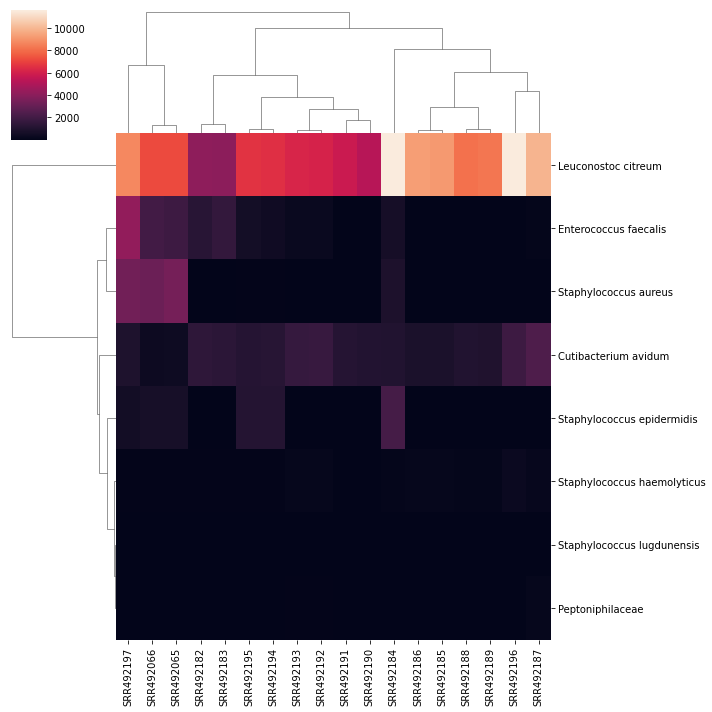

In [20]:
seaborn.clustermap(data)

## Question 5

This is mostly consistent with what I've seen in step 1 – the data is dominated by a few major groups. Of these, Lactobacillales is by far the dominant species, with Propionibacteriales as a distant second. One significant discrepancy, however, is that in the step 1 visualizations, Propionibacteriales proportions dropped dramatically in the first few days – here, it looks consierably more consistent (this also might be a consequence of how seaborn colors heatmaps?)